### Load Config

In [8]:
from yaml import load, Loader
from bunch import Bunch

stream = open("config.yaml", 'r')
config = Bunch(load(stream, Loader=Loader))

### Classification

#### Feature-based

In [33]:
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
import matplotlib.pyplot as plt
import seaborn as sns
import plotting_util as putil
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import get_scorer
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
import shap
import random

plt.rcParams['figure.facecolor'] = 'white'

SCORING = ['balanced_accuracy', 'roc_auc', 'f1_micro', 'average_precision', 'recall', 'precision']

PARAMETERS = {'n_estimators': [50, 100, 150], "max_features": ['sqrt', 'log2']}

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

SELECTED_FEATURES = {
    'gas': ['mean', 'std', 'rms', 'q5', 'q95'],
    'SteerSpeed': ['rms', 'q5', 'q95'],
    'gas_vel': ['std', 'rms', 'q5', 'q95'],
    'brake_vel': ['std', 'q5', 'q95'],
    'gas_acc': ['mean', 'std', 'rms'],
    'gas_jerk': ['std', 'rms'],
    'velocity': ['q95'],
    'acc': ['std', 'rms', 'q95'],
    'acc_jerk': ['kurtosis'],
    'lat_vel': ['std', 'rms'],
    'YawRate': ['rms'],
    'YawRate_acc': ['std', 'rms'],
    'lane_position': ['skewness'],
    'lane_distance_left_edge': ['q5'],
    'lane_crossing': ['skewness', 'kurtosis', 'sum'],
    'is_crossing_lane': ['std', 'rms', 'sum'],
    'Ttc': ['mean', 'std'],
    'TtcOpp': ['mean', 'std'],
    'Thw': ['skewness'],
    'Dhw': ['skewness', 'q5', 'q95'],
    'SpeedDif': ['mean', 'std', 'rms', 'q95'],
    'speed_limit_exceeded': ['sum']
}

#STATS = ['mean', 'std', 'min','max', 'q5', 'q95', 'range', 'iqrange', 'iqrange_5_95', 'sum', 'energy', 'skewness',
         #'kurtosis', 'peaks', 'rms', 'lineintegral', 'n_above_mean', 'n_below_mean', 'n_sign_changes', 'ptp']
STATS = ['mean', 'std', 'skewness', 'kurtosis', 'rms', 'q5', 'q95', 'sum']

SCENARIOS = ['highway', 'rural', 'town']

LOGO = LeaveOneGroupOut()

def collect_scores(scoring, y_true, y_pred):
    scores_dict = dict()
    for scorer in scoring:
        s = get_scorer(scorer)
        scores_dict[scorer] = s._score_func(y_true, y_pred)
    return scores_dict

top_n = 5
if config.plot_coef:
    fig, axes = putil.create_plot(len(config.window_sizes) * len(SIGNAL_COMBOS), len(SCENARIOS))
    putil.set_figure_size(fig, 40, 30)
    putil.set_fig_xlabel(fig, 'Coefficient', font_size=14)
    putil.set_fig_ylabel(fig, 'Top {} features'.format(top_n), font_size=14)
for i, window_size in enumerate(config.window_sizes):
    for j, combo in enumerate(SIGNAL_COMBOS):
        signal_string = ''
        can_data_features = []
        for signal in combo:
            signal_string += '_' + signal
            can_data_features.append(pd.read_parquet('out/can_data_features_{}_windowsize_{}s_new.parquet'.format(signal, window_size)))
        can_data_features = pd.concat(can_data_features, axis=1)
        stat_columns_list = [[col for col in can_data_features.columns if col in [sig + '_' + s for s in stats]] for sig, stats in SELECTED_FEATURES.items()]
        #stat_columns_list = [[col for col in can_data_features.columns if stat in col] for stat in STATS]
        stat_columns = []
        for item in stat_columns_list:
            stat_columns += item
        can_data_features = can_data_features[stat_columns]
        can_data_features.loc[:, 'label'] = 0
        can_data_features.loc[(slice(None), 'above', slice(None), slice(None)), 'label'] = 1

        can_data_features.dropna(axis=1, inplace=True)

        # drop below BAC level for binary classification
        can_data_features = can_data_features.drop('below', level=1)

        for k, scenario in enumerate(SCENARIOS):
            print('signals: {}, window size: {}s, scenario: {}'.format(signal_string, window_size, scenario))

            can_data_features_bin = can_data_features.loc[:, :, scenario, :]

            groups = list(can_data_features_bin.index.get_level_values('subject_id'))
            subject_ids = np.unique(groups)
            
            X = can_data_features_bin.drop(columns='label').to_numpy(dtype=np.float64)
            
            y = can_data_features_bin['label'].to_numpy()

            clf = None
            if config.classifier == 'log_regression':
                clf = LogisticRegression(
                penalty='l1', solver='saga', max_iter=1000, tol=1e-1, class_weight='balanced')
            elif config.classifier == 'random_forest':
                clf = XGBClassifier(objective='binary:hinge', n_estimators=150, scale_pos_weight=np.bincount(y)[0] / float(np.bincount(y)[1]), use_label_encoder=False, n_jobs=1)
            else:
                raise ValueError('Received unknown classifier string!')
            
            sfs = SequentialFeatureSelector(clf, n_features_to_select=20, scoring='roc_auc', n_jobs=len(subject_ids))
            #vt = VarianceThreshold(threshold=0.2)
            #sfm = SelectFromModel(clf, threshold=-np.inf, max_features=50)

            pipeline = make_pipeline(StandardScaler(), clf)

            cv = cross_validate(estimator=pipeline, X=X, y=y, scoring=SCORING, return_estimator=True, verbose=0,
                    return_train_score=True, cv=LOGO, groups=groups, n_jobs=len(subject_ids))
                
            if config.plot_coef and config.classifier == 'log_regression':
                coefficients = []
                for ind in range(len(subject_ids)):
                    est = cv['estimator'][ind]['logisticregression']
                    coefficients.append(est.coef_[0])
                coefficients = pd.DataFrame(coefficients, columns=can_data_features_bin.columns.to_list()[:-1])
                top_features = coefficients.mean(axis=0).abs().nlargest(top_n).index.to_list()
                ax = axes[i*len(SIGNAL_COMBOS) + j][k]
                if i*len(SIGNAL_COMBOS) + j == 0:
                    putil.set_ax_title(ax, scenario)
                sns.swarmplot(ax=ax, data=coefficients.loc[:, top_features], orient='h', size=2)
                putil.set_ax_grid_lines(ax, flag=True, style=':', axis='y', color='lightgrey')
                putil.set_ax_visible_spines(ax, False, False, True, False)


            # for subject_id, est in zip(subject_ids, cv['estimator']):
            #     if not os.path.exists('out/results/subject_{}'.format(subject_id)):
            #         os.makedirs('out/results/subject_{}'.format(subject_id))
            #     RocCurveDisplay.from_estimator(est, X, y)
            #     plt.savefig('out/results/subject_{}/roc_curve_windowsize_{}{}_{}.png'.format(subject_id, window_size, signal_string, scenario))
            #     plt.close()

            # shap_values = np.zeros(can_data_features_bin.shape)
            # for ind in range(len(subject_ids)):
            #     feature_names = can_data_features_bin.columns.to_list()[:-1]
            #     explainer = shap.LinearExplainer(cv['estimator'][ind]['logisticregression'], X, feature_names=feature_names)
            #     shap_values += explainer.shap_values(X)
            
            # shap_values /= len(range(subject_ids))

            # shap_values = pd.DataFrame(shap_values)
            # shap_values.columns = feature_names

            # ind = random.choice(range(len(subject_ids)))
            # feature_names = can_data_features_bin.columns.to_list()[:-1]
            # explainer = shap.Explainer(cv['estimator'][ind]['logisticregression'], X, feature_names=feature_names)
            # shap_obj = explainer(X)
            # shap.plots.beeswarm(shap_obj)

            # shap_values.set_index(can_data_features_bin.index).to_parquet(
            #     'out/shap_values_windowsize_{}{}_{}.parquet'.format(window_size, signal_string, scenario), index=True
            # )

            # indices = cv['estimator'][0]['selectfrommodel'].get_support(indices=True)
            # print(can_data_features_bin.columns[indices])
            
            results = pd.DataFrame({k:v for k,v in cv.items() if k not in ['estimator']}).set_index(subject_ids)
            mean = results.mean(axis=0).rename('mean')
            std = results.std(axis=0).rename('stddev')
            results = results.append(mean)
            results = results.append(std)
            results.to_csv(
                    'out/results/{}_pred_results_windowsize_{}{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index=True, header=True
                    )

if config.plot_coef:
    plt.tight_layout()
    plt.savefig('out/results/{}_coef_top_{}.png'.format(config.classifier, top_n))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


signals: _driver_behavior_vehicle_behavior, window size: 60s, scenario: highway
signals: _driver_behavior_vehicle_behavior, window size: 60s, scenario: rural
signals: _driver_behavior_vehicle_behavior, window size: 60s, scenario: town
signals: _driver_behavior_vehicle_behavior_navi, window size: 60s, scenario: highway
signals: _driver_behavior_vehicle_behavior_navi, window size: 60s, scenario: rural
signals: _driver_behavior_vehicle_behavior_navi, window size: 60s, scenario: town
signals: _driver_behavior_vehicle_behavior_radar, window size: 60s, scenario: highway
signals: _driver_behavior_vehicle_behavior_radar, window size: 60s, scenario: rural
signals: _driver_behavior_vehicle_behavior_radar, window size: 60s, scenario: town
signals: _driver_behavior_vehicle_behavior_navi_radar, window size: 60s, scenario: highway
signals: _driver_behavior_vehicle_behavior_navi_radar, window size: 60s, scenario: rural
signals: _driver_behavior_vehicle_behavior_navi_radar, window size: 60s, scenario:

#### Event-based

In [5]:
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
import matplotlib.pyplot as plt
import seaborn as sns
import plotting_util as putil
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import get_scorer
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
import shap
import random

SCORING = ['balanced_accuracy', 'roc_auc', 'f1_micro', 'average_precision', 'recall', 'precision']

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

#STATS = ['mean', 'std', 'min','max', 'q5', 'q95', 'range', 'iqrange', 'iqrange_5_95', 'sum', 'energy', 'skewness',
         #'kurtosis', 'peaks', 'rms', 'lineintegral', 'n_above_mean', 'n_below_mean', 'n_sign_changes', 'ptp']
STATS = ['mean', 'std', 'skewness', 'kurtosis', 'rms', 'q5', 'q95']

SCENARIOS = ['highway', 'rural', 'town']

LOGO = LeaveOneGroupOut()

can_data_events = []
for e in EVENTS:
    # if e == 'brake_to_gas':
    #     test = pd.read_parquet('out/can_data_{}_events.parquet'.format(e))
    #     test1 = test[test['steer_mean'].isna()]
    can_data_events.append(pd.read_parquet('out/can_data_{}_events.parquet'.format(e)))
can_data_events = pd.concat(can_data_events, axis=0)
stat_columns_list = [[col for col in can_data_events.columns if stat in col] for stat in STATS]
stat_columns = []
for item in stat_columns_list:
    stat_columns += item
can_data_events = can_data_events[['duration'] + stat_columns]

can_data_events.loc[:, 'label'] = 0
can_data_events.loc[(slice(None), 'above', slice(None), slice(None)), 'label'] = 1

can_data_events.dropna(axis=1, inplace=True)

# drop below BAC level for binary classification
can_data_events.drop('below', level=1, inplace=True)


for k, scenario in enumerate(SCENARIOS):
    print('scenario: {}'.format(scenario))

    can_data_events_bin = can_data_events.loc[:, :, scenario, :]

    groups = list(can_data_events_bin.index.get_level_values('subject_id'))
    subject_ids = np.unique(groups)
    
    X = can_data_events_bin.drop(columns='label').to_numpy(dtype=np.float64)
    
    y = can_data_events_bin['label'].to_numpy()

    clf = None
    if config.classifier == 'log_regression':
        clf = LogisticRegression(
        penalty='l1', solver='saga', max_iter=1000, tol=1e-1, class_weight='balanced')
    elif config.classifier == 'random_forest':
        clf = RandomForestClassifier(n_estimators=500, class_weight='balanced')
    else:
        raise ValueError('Received unknown classifier string!')
    
    #sfs = SequentialFeatureSelector(clf, n_features_to_select=5, scoring='roc_auc', n_jobs=len(subject_ids))
    #vt = VarianceThreshold(threshold=0.2)
    #sfm = SelectFromModel(clf, threshold=-np.inf, max_features=50)

    pipeline = make_pipeline(StandardScaler(), clf)

    cv = cross_validate(estimator=pipeline, X=X, y=y, scoring=SCORING, return_estimator=True, verbose=0,
            return_train_score=True, cv=LOGO, groups=groups, n_jobs=len(subject_ids))

    results = pd.DataFrame({k:v for k,v in cv.items() if k not in ['estimator']}).set_index(subject_ids)
    mean = results.mean(axis=0).rename('mean')
    std = results.std(axis=0).rename('stddev')
    results = results.append(mean)
    results = results.append(std)
    results.to_csv(
            'out/results/{}_pred_results_events_{}.csv'.format(
                config.classifier, scenario), index=True, header=True
            )

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


scenario: highway


/local/home/demircis/anaconda3/envs/DRIVE-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


scenario: rural
scenario: town


### Visualize Results

#### Feature-based

[[0.13345327 0.0049874  0.17717958 0.00575407]
 [0.14538143 0.00548938 0.18485141 0.00593972]
 [0.15331411 0.00558881 0.19014569 0.00594686]]


The handle <matplotlib.collections.PolyCollection object at 0x7fa77c8493d0> has a label of '_' which cannot be automatically added to the legend.
The handle <matplotlib.collections.PolyCollection object at 0x7fa77c7f92e0> has a label of '_' which cannot be automatically added to the legend.
The handle <matplotlib.collections.PolyCollection object at 0x7fa77c858130> has a label of '_' which cannot be automatically added to the legend.


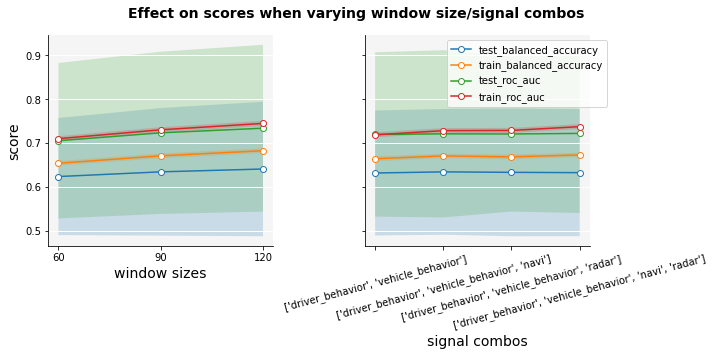

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

SIGNAL_COMBOS = [['driver_behavior', 'vehicle_behavior'], ['driver_behavior', 'vehicle_behavior', 'navi'],
                ['driver_behavior', 'vehicle_behavior', 'radar'], ['driver_behavior', 'vehicle_behavior', 'navi', 'radar']]

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

fig, axes = putil.create_plot(nrows=1, ncols=2, sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 10, 5)

# compare window sizes
avg_scores = []
avg_stddev = []
for window_size in config.window_sizes:
    avg_mean_scores = []
    stddev = []
    for combo in SIGNAL_COMBOS:
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', scores])
            stddev.append(results.loc['stddev', scores])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    stddev = np.array(stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[0].plot(config.window_sizes, avg_scores[:, i], markerfacecolor='white', marker="o")
    axes[0].fill_between(config.window_sizes, y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[0], config.window_sizes, config.window_sizes)
putil.set_ax_axis_labels(axes[0], x_label='window sizes', y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")

# compare signal combos
avg_scores = []
avg_stddev = []
for combo in SIGNAL_COMBOS:
    avg_mean_scores = []
    mean_stddev = []
    for window_size in config.window_sizes:
        signal_string = ''
        for signal in combo:
            signal_string += '_' + signal

        for scenario in ['highway', 'rural', 'town']:
            results = pd.read_csv('out/results/{}_pred_results_windowsize_{}{}_{}.csv'.format(
                        config.classifier, window_size, signal_string, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
            avg_mean_scores.append(results.loc['mean', scores])
            mean_stddev.append(results.loc['stddev', scores])
    avg_mean_scores = np.array(avg_mean_scores).mean(axis=0)
    mean_stddev = np.array(mean_stddev).mean(axis=0)
    avg_scores.append(avg_mean_scores)
    avg_stddev.append(mean_stddev)
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[1].plot(range(len(avg_scores)), avg_scores[:, i], markerfacecolor='white', marker="o")
    axes[1].fill_between(range(len(avg_scores)), y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[1], range(len(avg_scores)), SIGNAL_COMBOS, rotation=15)
putil.set_ax_axis_labels(axes[1], 'signal combos')
putil.set_ax_bg_color(axes[1], 'whitesmoke')
putil.set_ax_grid_lines(axes[1], True, axis="y", color="w")

scores = ['test_balanced_accuracy', '_', 'train_balanced_accuracy', '_', 'test_roc_auc', '_', 'train_roc_auc']
plt.legend(scores, bbox_to_anchor=(1.1, 1.0))
putil.set_fig_title(fig, title='Effect on scores when varying window size/signal combos', font_size=14, font_weight='bold')
#putil.set_plot_title(title='Effect on scores when varying window size/signal combos', font_weight='bold', pad=15)
plt.tight_layout()
plt.savefig('out/results/{}_scores_varying_window_size_signal_combos.png'.format(config.classifier))

#### Event-based

The handle <matplotlib.collections.PolyCollection object at 0x7fa7c0814a60> has a label of '_' which cannot be automatically added to the legend.
The handle <matplotlib.collections.PolyCollection object at 0x7fa7c0820220> has a label of '_' which cannot be automatically added to the legend.
The handle <matplotlib.collections.PolyCollection object at 0x7fa7c08208b0> has a label of '_' which cannot be automatically added to the legend.


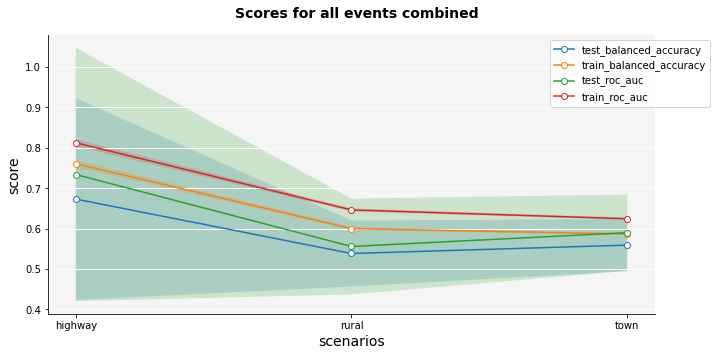

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_util as putil

plt.rcParams['figure.facecolor'] = 'white'

EVENTS = ['brake', 'brake_to_gas', 'gas', 'gas_to_brake', 'overtaking', 'road_sign', 'turning']

scores = ['test_balanced_accuracy', 'train_balanced_accuracy', 'test_roc_auc', 'train_roc_auc']

SCENARIOS = ['highway', 'rural', 'town']

fig, axes = putil.create_plot(nrows=None, ncols=None, sharey=True)
for ax in axes:
    putil.set_ax_visible_spines(ax, top=False, right=False)
putil.set_figure_size(fig, 10, 5)

# compare window sizes
avg_scores = []
avg_stddev = []
for scenario in SCENARIOS:
    results = pd.read_csv('out/results/{}_pred_results_events_{}.csv'.format(
                config.classifier, scenario), index_col=0, usecols=lambda x: x not in ['fit_time', 'score_time'])
    avg_scores.append(results.loc['mean', scores])
    avg_stddev.append(results.loc['stddev', scores])
avg_scores = np.array(avg_scores)
avg_stddev = np.array(avg_stddev)
for i in range(avg_scores.shape[1]):
    axes[0].plot(range(len(SCENARIOS)), avg_scores[:, i], markerfacecolor='white', marker="o")
    axes[0].fill_between(range(len(SCENARIOS)), y1=avg_scores[:, i]-avg_stddev[:, i], y2=avg_scores[:, i]+avg_stddev[:, i], alpha=0.2)
putil.set_ax_xticks(axes[0], range(len(SCENARIOS)), SCENARIOS)
putil.set_ax_axis_labels(axes[0], x_label='scenarios', y_label='score')
putil.set_ax_bg_color(axes[0], 'whitesmoke')
putil.set_ax_grid_lines(axes[0], True, axis="y", color="w")

scores = ['test_balanced_accuracy', '_', 'train_balanced_accuracy', '_', 'test_roc_auc', '_', 'train_roc_auc']
plt.legend(scores, bbox_to_anchor=(1.1, 1.0))
putil.set_fig_title(fig, title='Scores for all events combined', font_size=14, font_weight='bold')
#putil.set_plot_title(title='Effect on scores when varying window size/signal combos', font_weight='bold', pad=15)
plt.tight_layout()
plt.savefig('out/results/{}_scores_events_combined.png'.format(config.classifier))